<a href="https://colab.research.google.com/github/fongbubble/EFIMM0139_Social_Media_and_Web_Analytics/blob/main/Reddit_Ubisoft_Social_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sentence_transformers import SentenceTransformer

In [ ]:
!pip install praw pandas
!pip install contractions
!pip install sentence-transformers
!pip install langdetect
!pip install pyLDAvis
!pip install bertopic
!pip install transformers datasets
!pip install rouge_score
!pip install evaluate
!pip install bert_score
!pip install umap-learn
!pip install shap
!pip install spacy

In [ ]:
# library imports
import re
import string
import collections
from collections import Counter
from datetime import datetime
import praw
import contractions
#import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from langdetect import detect, DetectorFactory
#from sentence_transformers import SentenceTransformer
import umap
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, r2_score
from imblearn.combine import SMOTETomek
from transformers import pipeline, DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from scipy.special import softmax
from matplotlib.dates import DateFormatter
from bert_score import score
from evaluate import load
from sklearn.naive_bayes import MultinomialNB
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import shap
import spacy

# Load Data

In [ ]:
# setting the reddit API
reddit = praw.Reddit(
    client_id="WzGKXUT99iN-bhZ1YxTuyA",
    client_secret="qj06GmYlZ6TW6jfbLBkTEsedKmf6RA",
    user_agent="python:reddit_web_scrapper (by /u/Majestic_Guidance_74)"
)

print(reddit.read_only)

True


In [ ]:
# define the subreddits to scrape
subreddits = ["AssassinsCreedShadows", "assassinscreed", "ubisoft"]
post_list = []

for subreddit_name in subreddits:
    subreddit = reddit.subreddit(subreddit_name)
    # fetch the top 1000 hot posts from the selected subreddit
    for post in subreddit.hot(limit=1000):
        posted_date = datetime.utcfromtimestamp(post.created_utc).strftime("%Y-%m-%d %H:%M:%S")
        post_list.append([
            post.title,
            post.score,
            post.id,
            post.url,
            post.selftext,
            post.num_comments,
            posted_date
        ])

# define column names
columns = ["Title", "Upvotes", "Post ID", "URL", "Text", "Comment Count", "Posted Date"]

df = pd.DataFrame(post_list, columns=columns)
df.to_csv("reddit_ubisoft_1000.csv", index=False)

print("✅ Data collection complete! Saved to reddit_ubisoft_1000.csv")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

✅ Data collection complete! Saved to reddit_ubisoft_100.csv


In [ ]:
len(df)

2546

# Data Pre-processing

In [ ]:
df = pd.read_csv('reddit_ubisoft_1000.csv')
df

,Title,Upvotes,Post ID,URL,Text,Comment Count,Posted Date
0,[Megathread] Discuss Main Game Spoilers Here,1,1jfjvnx,https://www.reddit.com/r/AssassinsCreedShadows...,"Hello everyone,\n\nThis megathread is dedicate...",4,2025-03-20 08:03:22
1,NEW SPOILER POLICY FOR THE SUBREDDIT,86,1je2oul,https://www.reddit.com/r/AssassinsCreedShadows...,"Hello everyone,\n\nWith the game releasing thi...",25,2025-03-18 11:24:51
2,"Best looking game ever, a true next generation...",300,1jgnbue,https://v.redd.it/9359urg923qe1,Best looking game I've ever played,162,2025-03-21 18:07:23
3,"Don’t believe the hate, this game is complete ...",100,1jgtplp,https://i.redd.it/nxw2j7tcf4qe1.jpeg,This game has been nothing short of straight u...,56,2025-03-21 22:42:12
4,It's all in the details fellas!,132,1jgqnpe,https://i.redd.it/oskdvoabr3qe1.jpeg,Is this the first recorded TTP (Time To Penis)...,11,2025-03-21 20:27:26
...,...,...,...,...,...,...,...
2541,Delayed for polish,71,1fpvmfq,https://v.redd.it/rww9dv4aj5rd1,NaN,21,2024-09-26 13:01:18
2542,"NGL, I think it's freaking cool that Assassin'...",0,1fr7pbe,https://i.redd.it/nubdj1l8phrd1.jpeg,NaN,32,2024-09-28 05:56:03
2543,Anyone start buying Ubisoft now?,0,1fqu0y7,https://www.reddit.com/r/ubisoft/comments/1fqu...,I know this company is completely cooked. AC S...,21,2024-09-27 18:03:51
2544,the new Monopoly game that came out today?,4,1fq9odn,https://www.reddit.com/r/ubisoft/comments/1fq9...,anyone know how to unlock the locked game piec...,2,2024-09-26 23:07:36


# Data Cleaning

In [ ]:
# set seed
DetectorFactory.seed = 24150

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Comprehensive cleaning that performs the following steps:
    - Expands contractions
    - Removes URLs and HTML tags
    - Removes emojis, mentions, and hashtags
    - Removes non-ASCII characters
    - Removes punctuation and non-alphabetic characters
    - Reduces repeated characters (e.g., 'soooo' -> 'so')
    - Converts text to lowercase
    - Tokenizes and removes short tokens (<2 characters)
    - Removes stopwords
    - Lemmatizes tokens
    - Normalizes whitespace
    """
    if not isinstance(text, str):
        return ""

    # Expand contractions (e.g., "can't" -> "cannot")
    text = contractions.fix(text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove emojis using a regex pattern
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove mentions and hashtags
    text = re.sub(r'[@#]\w+', '', text)

    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Remove punctuation and non-alphabetic characters (keeping spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Reduce repeated characters (e.g., "soooo" -> "so")
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove tokens that are too short (e.g., single characters)
    tokens = [word for word in tokens if len(word) > 1]

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a string and normalize whitespace
    cleaned_text = " ".join(tokens)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

def is_english(text):
    """
    Returns True if the detected language of the text is English.
    """
    try:
        return detect(text) == 'en'
    except:
        return False

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
import nltk
nltk.download('wordnet', force=True)

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# list of columns to clean
text_columns = ["Title", "Text"]
for col in text_columns:
    df[col] = df[col].apply(clean_text)

In [ ]:
# remove duplicate rows
df.drop_duplicates(subset=text_columns, inplace=True)

# filter out rows where the main 'Text' column is not English
df = df[df["Text"].apply(is_english)]

In [ ]:
df.to_csv("reddit_ubisoft_1000_clean.csv", index=False)

print("✅ Data pre-processing complete! Saved to reddit_ubisoft_1000_clean.csv")

✅ Data pre-processing complete! Saved to reddit_ubisoft_100_clean.csv


# Word Cloud

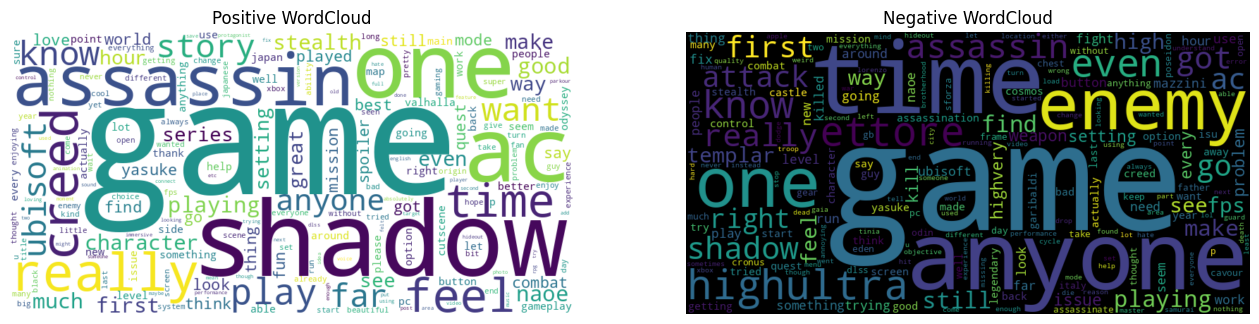

In [ ]:
# use only the first 1000 rows where sentiment was labeled
df_subset = df.loc[:999]

# combine text for each sentiment group into a single string
positive_text = " ".join(df_subset.loc[df_subset['sentiment'] == 1, 'Text'].dropna().tolist())
negative_text = " ".join(df_subset.loc[df_subset['sentiment'] == 0, 'Text'].dropna().tolist())

# create wordcloud for positive/negative texts
wordcloud_positive = WordCloud(width=800, height=400, background_color='white',
                               collocations=False).generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black',
                               collocations=False).generate(negative_text)

# plotting the word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive WordCloud')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative WordCloud')
plt.show()

# Train-test split

In [ ]:
# use only the first 1000 rows
df_subset = df.loc[:999].copy()

# define features (X) and target (y)
X = df_subset['Text']
y = df_subset['sentiment']

# split the data: 60% training and 40% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=24150)
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 600
Testing set size: 400


In [ ]:
# initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# fit the vectorizer
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.13      0.23       156
         1.0       0.64      0.99      0.78       244

    accuracy                           0.66       400
   macro avg       0.76      0.56      0.51       400
weighted avg       0.73      0.66      0.57       400



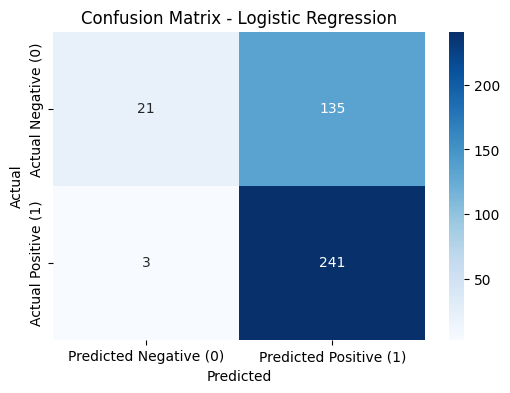

In [ ]:
# train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# predict on the test set
y_pred = model.predict(X_test_tfidf)

# compute the confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative (0)", "Predicted Positive (1)"],
            yticklabels=["Actual Negative (0)", "Actual Positive (1)"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Class Imbalance

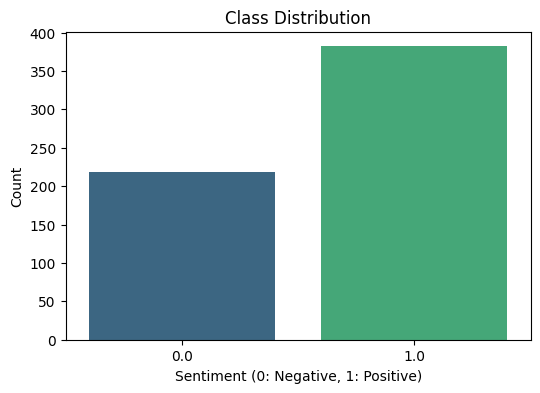

In [ ]:
# plot the class distribution before SMOTETomek
counts = collections.Counter(y_train)
plt.figure(figsize=(6,4))
sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")
plt.title('Class Distribution')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

In [ ]:
# apply a resampling combination technique: SMOTETomek
smote_tomek = SMOTETomek(random_state=24150)
X_train_res, y_train_res = smote_tomek.fit_resample(X_train_tfidf, y_train)

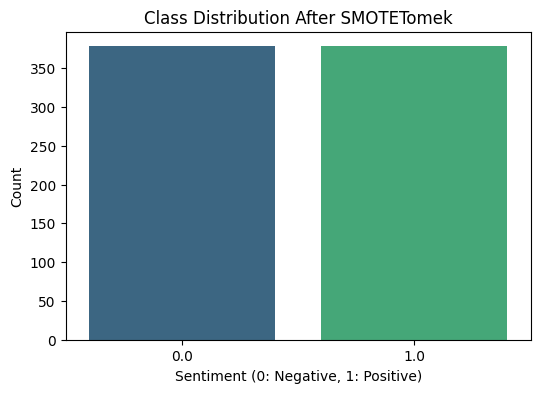

In [ ]:
# plot the class distribution after SMOTETomek
counts = collections.Counter(y_train_res)
plt.figure(figsize=(6,4))
sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")
plt.title('Class Distribution After SMOTETomek')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()


Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.52      0.60       156
         1.0       0.74      0.87      0.80       244

    accuracy                           0.73       400
   macro avg       0.73      0.70      0.70       400
weighted avg       0.73      0.73      0.72       400



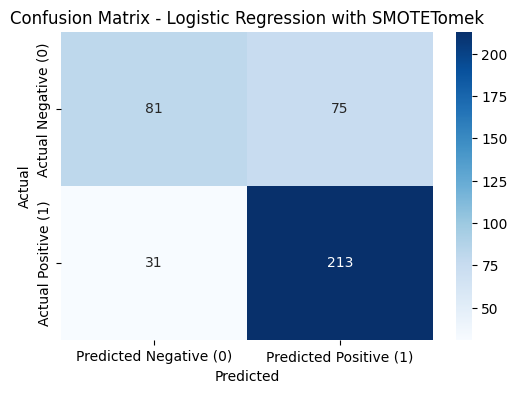

In [ ]:
# train a Logistic Regression model again after SMOTETomek was applied
model = LogisticRegression(max_iter=1000)
model.fit(X_train_res, y_train_res)

# predict on the test set
y_pred = model.predict(X_test_tfidf)

# compute the confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative (0)", "Predicted Positive (1)"],
            yticklabels=["Actual Negative (0)", "Actual Positive (1)"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression with SMOTETomek')
plt.show()


Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.47      0.57       156
         1.0       0.72      0.87      0.79       244

    accuracy                           0.72       400
   macro avg       0.71      0.67      0.68       400
weighted avg       0.72      0.72      0.70       400



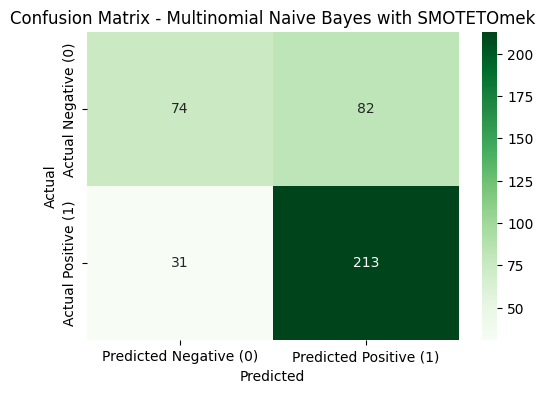

In [ ]:
# train a Multinomial Naive Bayes model after SMOTETomek was applied
model = MultinomialNB()
model.fit(X_train_res, y_train_res)

# predict on the test set
y_pred = model.predict(X_test_tfidf)

# compute the confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Predicted Negative (0)", "Predicted Positive (1)"],
            yticklabels=["Actual Negative (0)", "Actual Positive (1)"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Multinomial Naive Bayes with SMOTETOmek')
plt.show()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: supanufong (supanufong-university-of-bristol) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'train_runtime': 649.8904, 'train_samples_per_second': 0.923, 'train_steps_per_second': 0.029, 'train_loss': 0.6336456098054585, 'epoch': 1.0}


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Classification Report (Hybrid):
              precision    recall  f1-score   support

           0       1.00      0.44      0.61       156
           1       0.74      1.00      0.85       244

    accuracy                           0.78       400
   macro avg       0.87      0.72      0.73       400
weighted avg       0.84      0.78      0.76       400



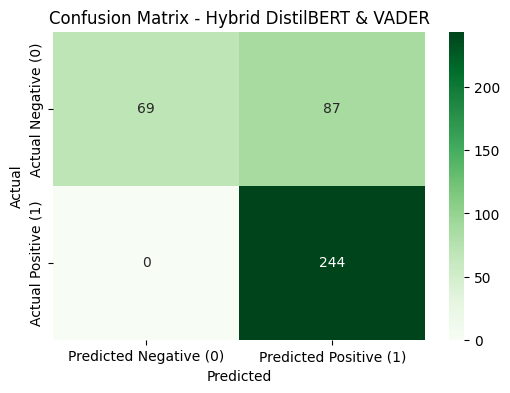

In [ ]:
train_df = pd.DataFrame({'text': X_train, 'label': y_train.astype(int)})
test_df = pd.DataFrame({'text': X_test, 'label': y_test.astype(int)})

# create Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# load tokenizer and model
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=128)

# tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="no",
    logging_steps=50,
    seed=24150,
    disable_tqdm=True,
    fp16=True,
    dataloader_num_workers=2
)

# initialize the trainer and fine-tune DistilBERT
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

# --- Hybrid Prediction: DistilBERT + VADER ---

# Get DistilBERT predictions on the test set
preds = trainer.predict(test_dataset)
distil_logits = preds.predictions
distil_probs = softmax(distil_logits, axis=1)
distil_pred = np.argmax(distil_probs, axis=1)

# initialize VADER
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Compute VADER predictions
vader_pred = []
vader_confidences = []
for text in X_test:
    compound = sia.polarity_scores(text)['compound']
    label = 1 if compound >= 0 else 0
    vader_pred.append(label)
    vader_confidences.append(abs(compound))

vader_pred = np.array(vader_pred)
vader_confidences = np.array(vader_confidences)

# Hybrid
threshold = 0.5
hybrid_pred = []
for i in range(len(X_test)):
    if vader_confidences[i] >= threshold:
        hybrid_pred.append(vader_pred[i])
    else:
        hybrid_pred.append(distil_pred[i])
hybrid_pred = np.array(hybrid_pred)

# evaluate the hybrid predictions
print("Classification Report (Hybrid):")
print(classification_report(y_test.astype(int), hybrid_pred))

cm = confusion_matrix(y_test.astype(int), hybrid_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Predicted Negative (0)", "Predicted Positive (1)"],
            yticklabels=["Actual Negative (0)", "Actual Positive (1)"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Hybrid DistilBERT & VADER')
plt.show()

# api for wandb
#c81a6032f97fec8ce73a5fbdb1bf5607564f9782

# Hybrid Sentiment using VADER & DistilBERT for all data

In [ ]:
df = pd.read_csv('reddit_ubisoft_1000_clean.csv')

# initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# initialize transformer sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# load model and tokenizer for SHAP explanations
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

def transformer_predict(texts):
    """
    Given a list of texts, returns the probability of positive sentiment for each.
    Ensures that every input is a string.
    """
    texts = [str(text) for text in texts]
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=1).detach().numpy()[:, 1]
    return probs

# create a SHAP explainer
explainer = shap.Explainer(transformer_predict, tokenizer)

def explain_sentiment(text, num_samples=100):
    """
    Generate and display a SHAP explanation for the transformer sentiment model for a given text.
    num_samples sets the maximum evaluations for SHAP.
    """
    text = str(text)
    # compute SHAP values
    shap_values = explainer([text], max_evals=num_samples)
    shap.initjs()
    shap.plots.text(shap_values[0])

def hybrid_sentiment(text):
    """
    Compute a hybrid sentiment score by combining VADER's compound score and
    a transformer-based sentiment score.
    """
    if not isinstance(text, str) or text.strip() == "":
        return 0.0

    # VADER sentiment score
    vader_scores = sia.polarity_scores(text)
    vader_compound = vader_scores['compound']

    # transformer sentiment analysis with truncation
    transformer_result = sentiment_pipeline(text, truncation=True, max_length=512)[0]
    # for a positive label, use the score; for negative, use the negative of the score.
    transformer_sentiment = transformer_result['score'] if transformer_result['label'] == 'POSITIVE' else -transformer_result['score']

    # combine the two scores (simple average)
    hybrid_score = (vader_compound + transformer_sentiment) / 2
    return hybrid_score

# apply the hybrid sentiment analysis and add the result as a new column
df['Hybrid_Sentiment'] = df['Text'].apply(hybrid_sentiment)

print(df[['Text', 'Hybrid_Sentiment']].head())

df.to_csv("reddit_ubisoft_100_hybrid_sentiment.csv", index=False)
print("✅ Hybrid sentiment analysis complete and saved to reddit_ubisoft_100_hybrid_sentiment.csv")

# Generate a SHAP explanation
sample_text = df['Text'].iloc[0]
print("Generating SHAP explanation for the sample text:")
explain_sentiment(sample_text)

df.to_csv("reddit_ubisoft_100_hybrid_sentiment.csv", index=False)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


                                                Text  Hybrid_Sentiment
0  hello everyone megathread dedicated discussing...          0.737392
1  hello everyone game releasing week similarly r...         -0.076248
2                      best looking game ever played          0.882427
3  game nothing short straight ninja shit touched...          0.779841
4  first recorded ttp time penis assassin creed s...         -0.456548
✅ Hybrid sentiment analysis complete and saved to reddit_ubisoft_100_hybrid_sentiment.csv
Generating SHAP explanation for the sample text:


  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.08s/it]               


# LDA

In [ ]:
df = pd.read_csv("reddit_ubisoft_1000_hybrid_sentiment.csv")
docs = df['Text'].tolist()
tokenized = [doc.split() for doc in docs]

# ------------------ LDA ------------------
dictionary = corpora.Dictionary(tokenized)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in tokenized]
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=20, random_state=24150, passes=5)
lda_topics = [[part.split('*')[1].replace('"','').strip() for part in topic.split(" + ")]
              for idx, topic in lda.print_topics(num_words=10)]
coherence_lda = CoherenceModel(model=lda, texts=tokenized, dictionary=dictionary, coherence='c_v').get_coherence()
diversity_lda = len(set(word for topic in lda_topics for word in topic)) / (20 * 10)
df['LDA_Topic'] = [max(lda.get_document_topics(bow), key=lambda x: x[1])[0] for bow in corpus]

# ------------------ BERTopic ------------------
np.random.seed(24150)
topic_model = BERTopic(verbose=False)
bt_topics, _ = topic_model.fit_transform(docs)
df['BERTopic_Topic'] = bt_topics
# exclude outlier topic (-1)
bt_topic_ids = [t for t in topic_model.get_topic_info()['Topic'] if t != -1]
bt_topics_list = [ [word for word, _ in topic_model.get_topic(t)[:10]] for t in bt_topic_ids ]
coherence_bt = CoherenceModel(topics=bt_topics_list, texts=tokenized, dictionary=dictionary, coherence='c_v').get_coherence()
diversity_bt = len(set(word for topic in bt_topics_list for word in topic)) / (len(bt_topics_list)*10)

# ------------------ Results ------------------
print("LDA Coherence:", coherence_lda)
print("LDA Diversity:", diversity_lda)
print("BERTopic Coherence:", coherence_bt)
print("BERTopic Diversity:", diversity_bt)

df.to_csv("reddit_ubisoft_lda_bertopic_comparison.csv", index=False)
print("✅ Saved to reddit_ubisoft_lda_bertopic_comparison.csv")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

LDA Coherence: 0.36858556455573466
LDA Diversity: 0.415
BERTopic Coherence: 0.5040810304438639
BERTopic Diversity: 0.80625
✅ Saved to reddit_ubisoft_lda_bertopic_comparison.csv


Number of Topics (nr_topics): 2, BERTopic Coherence Score: 0.4067
Number of Topics (nr_topics): 3, BERTopic Coherence Score: 0.4232
Number of Topics (nr_topics): 4, BERTopic Coherence Score: 0.5272
Number of Topics (nr_topics): 5, BERTopic Coherence Score: 0.4540
Number of Topics (nr_topics): 6, BERTopic Coherence Score: 0.4848
Number of Topics (nr_topics): 7, BERTopic Coherence Score: 0.4760
Number of Topics (nr_topics): 8, BERTopic Coherence Score: 0.4314
Number of Topics (nr_topics): 9, BERTopic Coherence Score: 0.5308
Number of Topics (nr_topics): 10, BERTopic Coherence Score: 0.4815


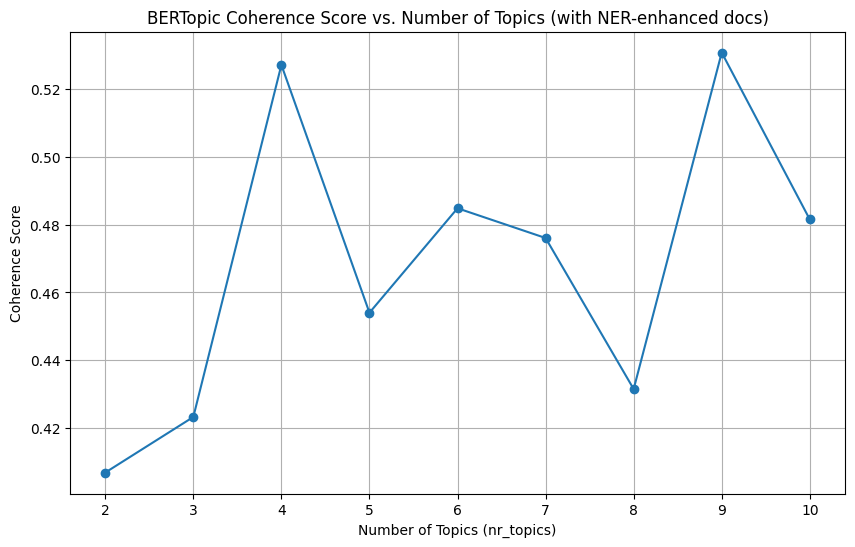


Optimal Number of Topics (nr_topics): 9

=== BERTopic: 8 Topics Found ===
Topic 0: ['game', 'ac', 'like', 'one', 'assassin', 'would', 'creed', 'first', 'time', 'make']
Topic 1: ['ubisoft', 'account', 'game', 'steam', 'xbox', 'play', 'pc', 'connect', 'anyone', 'get']
Topic 2: ['game', 'highultra', 'fps', 'button', 'anyone', 'dlss', 'gb', 'high', 'issue', 'setting']
Topic 3: ['naoe', 'yasuke', 'canon', 'like', 'game', 'one', 'play', 'choice', 'character', 'would']
Topic 4: ['chest', 'castle', 'legendary', 'samurai', 'inventory', 'objective', 'find', 'killed', 'location', 'got']
Topic 5: ['tomorrow', 'day', 'title', 'far', 'yesterday', 'wait', 'game', 'nightshift', 'rectify', 'nightshifts']
Topic 6: ['katana', 'blade', 'weapon', 'kusarigama', 'attack', 'hidden', 'sword', 'animation', 'perk', 'assassination']
Topic 7: ['song', 'music', 'shazam', 'track', 'theme', 'official', 'ost', 'anything', 'segment', 'oda']
CSV file saved as reddit_ubisoft_lda_bertopic_optimal_topics.csv


In [ ]:
# ----------------------------
# Part 1: Enhance Documents with NER
# ----------------------------
nlp = spacy.load("en_core_web_sm")

docs_enhanced = []
for doc in docs:
    doc_nlp = nlp(doc)
    ner_entities = [ent.text for ent in doc_nlp.ents]
    enhanced_doc = " ".join(ner_entities) + " " + doc
    docs_enhanced.append(enhanced_doc)

# ----------------------------
# Part 2: Determine the Optimal Number of Topics
# ----------------------------
# Define the range from 2 to 11 topics.
topic_range_bt = range(2, 11)
coherence_scores_bt = []
models = {}

# Use a fixed seed for reproducibility
np.random.seed(24150)

for num in topic_range_bt:
    topic_model_bt = BERTopic(nr_topics=num, verbose=False)
    bt_topics, _ = topic_model_bt.fit_transform(docs_enhanced)

    # retrieve topic info and exclude the outlier (-1)
    topic_info_bt = topic_model_bt.get_topic_info()
    bt_topic_ids = [t for t in topic_info_bt['Topic'] if t != -1]

    # extract top 10 words for each valid topic
    bt_topics_list = [
        [word for word, _ in topic_model_bt.get_topic(t)[:10]]
        for t in bt_topic_ids
    ]

    # compute the coherence score using the c_v measure
    coherence_model_bt = CoherenceModel(
        topics=bt_topics_list,
        texts=tokenized,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model_bt.get_coherence()
    coherence_scores_bt.append(coherence_score)

    print(f"Number of Topics (nr_topics): {num}, BERTopic Coherence Score: {coherence_score:.4f}")
    models[num] = topic_model_bt

# plot coherence scores for visualization
plt.figure(figsize=(10, 6))
plt.plot(list(topic_range_bt), coherence_scores_bt, marker='o', linestyle='-')
plt.xlabel("Number of Topics (nr_topics)")
plt.ylabel("Coherence Score")
plt.title("BERTopic Coherence Score vs. Number of Topics (with NER-enhanced docs)")
plt.xticks(list(topic_range_bt))
plt.grid(True)
plt.show()

# identify the optimal number of topics (with highest coherence score)
max_index = np.argmax(coherence_scores_bt)
optimal_topics = list(topic_range_bt)[max_index]
print(f"\nOptimal Number of Topics (nr_topics): {optimal_topics}")

# ----------------------------
# Part 3: Fit BERTopic Using the Optimal Number of Topics
# ----------------------------
topic_model_optimal = BERTopic(nr_topics=optimal_topics, verbose=False)
topics_opt, probs_opt = topic_model_optimal.fit_transform(docs_enhanced)

topic_model_optimal = topic_model_optimal.reduce_topics(docs_enhanced, nr_topics=optimal_topics)
topics_opt, probs_opt = topic_model_optimal.transform(docs_enhanced)

topic_info_opt = topic_model_optimal.get_topic_info()
bertopic_topics = topic_model_optimal.get_topics()

num_bertopic_topics = len([t for t in topic_info_opt['Topic'] if t != -1])
print(f"\n=== BERTopic: {num_bertopic_topics} Topics Found ===")

# Print the top 10 words for each topic (skip the outlier topic -1)
for topic_id, words in bertopic_topics.items():
    if topic_id == -1:
        continue
    top_words = [word for word, _ in words[:10]]
    print(f"Topic {topic_id}: {top_words}")

df['BERTopic_Optimal'] = topics_opt
df.to_csv("reddit_ubisoft_lda_bertopic_optimal_topics.csv", index=False)
print("CSV file saved as reddit_ubisoft_lda_bertopic_optimal_topics.csv")

<ipython-input-28-8e6bf5d54731>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  topic_sentiment = df_bt_filtered.groupby('BERTopic_Optimal').apply(


   BERTopic_Optimal  Weighted_Average_Sentiment
0                 0                    0.025364
1                 1                   -0.284135
2                 2                   -0.115841
3                 3                   -0.077137
4                 4                   -0.291547
5                 5                    0.214838
6                 6                   -0.336047
7                 7                   -0.020543


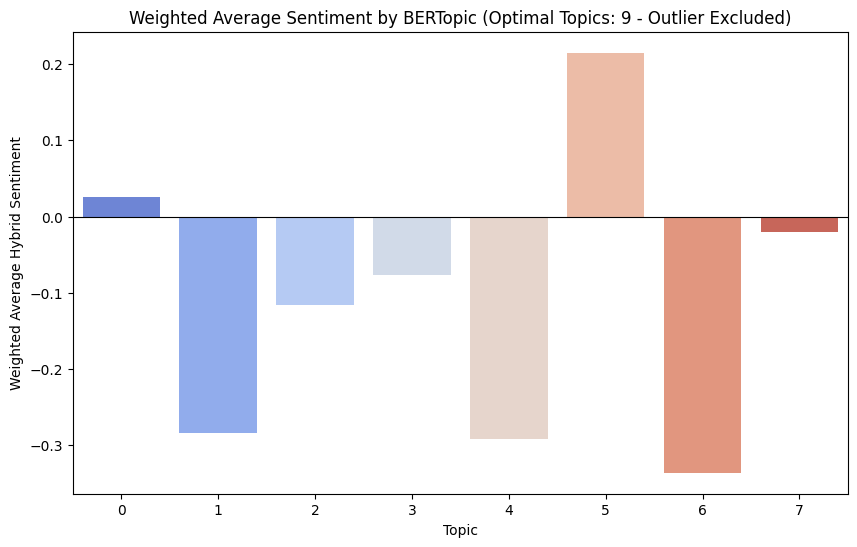

In [ ]:
topics_opt, probs_opt = topic_model_optimal.transform(docs_enhanced)
df['BERTopic_Optimal'] = topics_opt

def extract_assigned_prob(prob):
    if isinstance(prob, (list, np.ndarray)):
        return max(prob)
    return prob

df['Assigned_Prob'] = [extract_assigned_prob(prob) for prob in probs_opt]

# filter out the outlier topic (-1)
df_bt_filtered = df[df['BERTopic_Optimal'] != -1]

# Group by topic and compute the weighted average sentiment using the assigned probability as weights
topic_sentiment = df_bt_filtered.groupby('BERTopic_Optimal').apply(
    lambda x: np.average(x['Hybrid_Sentiment'], weights=x['Assigned_Prob'])
).reset_index(name='Weighted_Average_Sentiment')
print(topic_sentiment)

# plot a bar chart to visualise the weighted average sentiment for each topic
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='BERTopic_Optimal', y='Weighted_Average_Sentiment', data=topic_sentiment, palette='coolwarm')
plt.title(f"Weighted Average Sentiment by BERTopic (Optimal Topics: {optimal_topics} - Outlier Excluded)")
plt.xlabel("Topic")
plt.ylabel("Weighted Average Hybrid Sentiment")
plt.axhline(0, color='black', linewidth=0.8)
plt.show()

# Summarizer

## BART

In [ ]:
nlp = spacy.load("en_core_web_sm")

# initialize the BART summarizer
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize_topic(topic_number, df, topic_col='BERTopic_Optimal', text_col='Text',
                    sample_size=5, max_length=50, min_length=20,
                    truncate_text=True, truncation_length=512):
    """
    Summarize texts for a given topic. If truncate_text is True, the combined text is limited to truncation_length.
    Otherwise, the full text is used.
    """
    topic_texts = df[df[topic_col] == topic_number][text_col].tolist()

    if len(topic_texts) > sample_size:
        topic_texts = list(np.random.choice(topic_texts, size=sample_size, replace=False))

    ner_enhanced_texts = []
    for text in topic_texts:
        text = str(text)
        doc = nlp(text)
        entities = " ".join([ent.text for ent in doc.ents])
        enhanced_text = entities + " " + text
        ner_enhanced_texts.append(enhanced_text)

    combined_text = " ".join(ner_enhanced_texts)

    if truncate_text:
        combined_text = combined_text[:truncation_length]

    if not combined_text.strip():
        return "No content to summarize."

    summary = summarizer(combined_text, max_length=max_length, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

topics = sorted(df[df['BERTopic_Optimal'] != -1]['BERTopic_Optimal'].unique())
for topic in topics:
    print(f"Summary for Topic {topic}:")
    summary_text = summarize_topic(
        topic_number=topic,
        df=df,
        topic_col='BERTopic_Optimal',
        text_col='Text',
        sample_size=5,
        max_length=50,
        min_length=20,
        truncate_text=True,
        truncation_length=512
    )
    print(summary_text)
    print("-" * 50)

Device set to use cpu


Summary for Topic 0:
 ac honor release day assassin creed shadow put together fun question short quiz based series far get fun hooray ac shadow  title company guy think could leverage ubisofts ip turn company around ac valhalla game lately feel ac shadow new game
--------------------------------------------------
Summary for Topic 1:
 ac unity already clicked download completely download say reward successfully redeemed download button anymore ac hi wanted know anyone bought ezio collection pc whether support xbox controller find answer anywhere. ac found video fix assassin creed controller trigger fix hope help anyone else
--------------------------------------------------
Summary for Topic 2:
Sprint hold is the default binding for parkour. Use sprint hold parryblock grappling hook crouchprone light attackassassinate square heavy attack triangle int.
--------------------------------------------------
Summary for Topic 3:
yasuke naoe played hour blown away good one combat feel great st

Your max_length is set to 50, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


 shinobis furry tanto level loved disapeared try engrave armor pen anyone else experienced somehow stash checked really look like got destroyed somehow still visuals inventory equipment disappeared noticed tried double assassinate could tried swap tanto exist anymore  find anywhere
--------------------------------------------------
Summary for Topic 5:
The game is expected to be released in the U.S. on September 28. The game will be released on PC, Mac and PlayStation.
--------------------------------------------------
Summary for Topic 6:
Naginatanever really proper one outside soul game even proper would expect chain sickle also exciting wish added one type weapon though since katana see see. far wait protagonist become assassin officially naoe katana multiple nothing really serious something found
--------------------------------------------------
Summary for Topic 7:
Half shadow ost spotify track hour half eating good  edit forgot add asking ac shadow theme play nagatos death scene

In [ ]:
# initialize the T5 summarizer
summarizer_t5 = pipeline("summarization", model="t5-base")

def summarize_topic_t5(topic_number, df, topic_col='BERTopic_Optimal', text_col='Text',
                       sample_size=5, max_length=50, min_length=20):
    """
    Summarize documents for a given topic using T5.
    The function takes a random sample of documents if the topic has more than `sample_size`.
    """
    topic_texts = df[df[topic_col] == topic_number][text_col].tolist()

    if len(topic_texts) > sample_size:
        topic_texts = list(np.random.choice(topic_texts, size=sample_size, replace=False))

    combined_text = "summarize: " + " ".join(topic_texts)

    if not combined_text.strip():
        return "No content to summarize."

    summary = summarizer_t5(combined_text, max_length=max_length, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

topics = sorted(df[df['BERTopic_Optimal'] != -1]['BERTopic_Optimal'].unique())
for topic in topics:
    print(f"Summary for Topic {topic}:")
    summary_text = summarize_topic_t5(
        topic_number=topic,
        df=df,
        topic_col='BERTopic_Optimal',
        sample_size=5,
        max_length=50,
        min_length=20
    )
    print(summary_text)
    print("-" * 50)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu


Summary for Topic 0:
theradbrads ac shadow is one of the most popular franchises of all time . ezio brotherhood was one of my favourite games . the game was released in november .
--------------------------------------------------
Summary for Topic 1:
assassin creed pc physicial edition afaik ubisoft account already connected another xbox account . support ticket ever since ever get canned response legally required second third timeline 
--------------------------------------------------
Summary for Topic 2:
yt fps issue lately however following step got dx run administrator task manager game launch mode offline tried reinstall game even went game file checked exe thingy see running admin please help change run program administrator turned 
--------------------------------------------------
Summary for Topic 3:
yasuke naoe th oda nobunaga iga mozambique eagle hidden blade dragon bonus dlc another promo .
--------------------------------------------------
Summary for Topic 4:
katano cas

In [ ]:
# define the generated summary
bart_summary = "Your BART-generated summary here."
t5_summary = "Your T5-generated summary here."
reference_summary = "The reference summary."

# load the ROUGE metric for comparison
rouge = load("rouge")

result_bart = rouge.compute(predictions=[bart_summary], references=[reference_summary])
result_t5 = rouge.compute(predictions=[t5_summary], references=[reference_summary])

print("BART ROUGE:", result_bart)
print("T5 ROUGE:", result_t5)

# compute BERTScore for comparison
P_bart, R_bart, F1_bart = score([bart_summary], [reference_summary], lang="en")
P_t5, R_t5, F1_t5 = score([t5_summary], [reference_summary], lang="en")

print("BART BERTScore F1:", F1_bart.mean().item())
print("T5 BERTScore F1:", F1_t5.mean().item())

BART ROUGE: {'rouge1': 0.25, 'rouge2': 0.0, 'rougeL': 0.25, 'rougeLsum': 0.25}
T5 ROUGE: {'rouge1': 0.25, 'rouge2': 0.0, 'rougeL': 0.25, 'rougeLsum': 0.25}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BART BERTScore F1: 0.8950830698013306
T5 BERTScore F1: 0.8937090039253235


### BART with NER (Best)

In [ ]:
nlp = spacy.load("en_core_web_sm")

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize_topic(topic_number, df, bertopic_optimal, topic_col='BERTopic_Optimal', text_col='Text',
                    sample_size=5, max_length=50, min_length=20, truncate_text=False, truncation_length=512):
    """
    Summarize texts for a given topic using both the top words stored by BERTopic and NER-enhanced texts.
    If truncate_text is True, the combined text is limited to truncation_length.
    """
    if topic_number in bertopic_topics:
        top_words = [word for word, _ in bertopic_topics[topic_number][:10]]
        topic_words_str = " ".join(top_words)
    else:
        topic_words_str = ""

    topic_texts = df[df[topic_col] == topic_number][text_col].tolist()

    if len(topic_texts) > sample_size:
        topic_texts = list(np.random.choice(topic_texts, size=sample_size, replace=False))

    ner_enhanced_texts = []
    for text in topic_texts:
        text = str(text)
        doc = nlp(text)
        entities = " ".join([ent.text for ent in doc.ents])
        enhanced_text = entities + " " + text
        ner_enhanced_texts.append(enhanced_text)

    combined_text = " ".join(ner_enhanced_texts)

    combined_text = topic_words_str + " " + combined_text

    if truncate_text:
        combined_text = combined_text[:truncation_length]

    if not combined_text.strip():
        return "No content to summarize for this topic."

    try:
        summary = summarizer(combined_text, max_length=max_length, min_length=min_length, do_sample=False, truncation=True)
        return summary[0]['summary_text']
    except IndexError:
        print(f"IndexError occurred for topic {topic_number}. Skipping...")
        return "Could not generate summary due to IndexError."


topics = sorted(df[df['BERTopic_Optimal'] != -1]['BERTopic_Optimal'].unique())
for topic in topics:
    print(f"Summary for Topic {topic}:")
    summary_text = summarize_topic(topic, df, bertopic_topics, sample_size=5, max_length=50, min_length=20, truncate_text=False)
    print(summary_text)
    print("-" * 50)

Device set to use cpu


Summary for Topic 0:


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


IndexError occurred for topic 0. Skipping...
Could not generate summary due to IndexError.
--------------------------------------------------
Summary for Topic 1:
 ubisoft account game steam xbox play pc connect anyone get xbox six xbox friend computer going rainbow six want know going cost money party ubisoft like playstation like subscription something hour wanted ask question regarding preorder availability tied claw aw
--------------------------------------------------
Summary for Topic 2:
Game look phenomenal expecting good incredible  start game seen couple npc fishing amazing graphic atmosphere game would wish could chill fish sometimes  call optimized game changed setting around high mediem still problem  eagle vision tagging enemy always important element maintaining stealth ac
--------------------------------------------------
Summary for Topic 3:
 naoe yasuke canon like game one play choice character would yasuked naoe played hour blown away good one combat feel great stealt

Your max_length is set to 50, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


chest castle legendary samurai inventory objective find killed location got  found guy ouyamazaki village southern entrance yamashiro easter egg bug  go objective screen let select anything see mission marker map resorted running around map hoping something pop one
--------------------------------------------------
Summary for Topic 5:
Tomorrow day title far yesterday wait game nightshift rectify nightshifts  title  buisne  curious excited try would let  think far  thought would share news article.
--------------------------------------------------
Summary for Topic 6:
 katana blade weapon kusarigama attack hidden sword animation perk assassination katana looked online could find anything yet anyone know weapon perksengravings work equipped weapon like odyssey tantos perk still active equipped wielding katana thanks guy 
--------------------------------------------------
Summary for Topic 7:
Game has a short snippet cutscene. Use this cutscene to help you find the soundtrack. Listened 

# Regression Analysis

In [ ]:
df = pd.read_csv("reddit_ubisoft_lda_bertopic_optimal_topics.csv")

R-squared: 0.005063481056253871


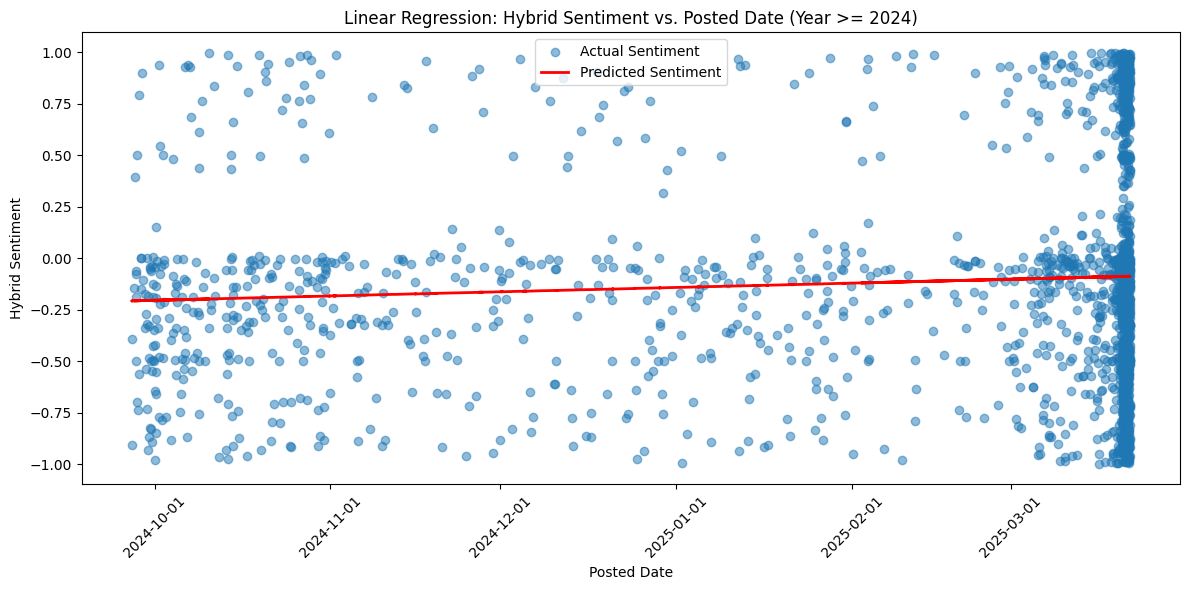

In [ ]:
df['Posted Date'] = pd.to_datetime(df['Posted Date'])
df = df[df['Posted Date'].dt.year >= 2024]
df['Date_Ordinal'] = df['Posted Date'].apply(lambda x: x.toordinal())
X = df[['Date_Ordinal']]
y = df['Hybrid_Sentiment']

# initialize and fit the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# predict sentiment values
y_pred = lin_reg.predict(X)

# calculate the R-squared value
r2 = r2_score(y, y_pred)
print("R-squared:", r2)

# plot the actual vs. predicted sentiment over time
plt.figure(figsize=(12, 6))
plt.scatter(df['Posted Date'], y, label="Actual Sentiment", alpha=0.5)
plt.plot(df['Posted Date'], y_pred, color='red', label="Predicted Sentiment", linewidth=2)
plt.xlabel("Posted Date")
plt.ylabel("Hybrid Sentiment")
plt.title("Linear Regression: Hybrid Sentiment vs. Posted Date (Year >= 2024)")
plt.legend()

date_form = DateFormatter("%Y-%m-%d")
plt.gca().xaxis.set_major_formatter(date_form)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df['BERTopic_Optimal'].unique()

array([-1,  2,  0,  5,  3,  7,  1,  4,  6])

# Heatmap

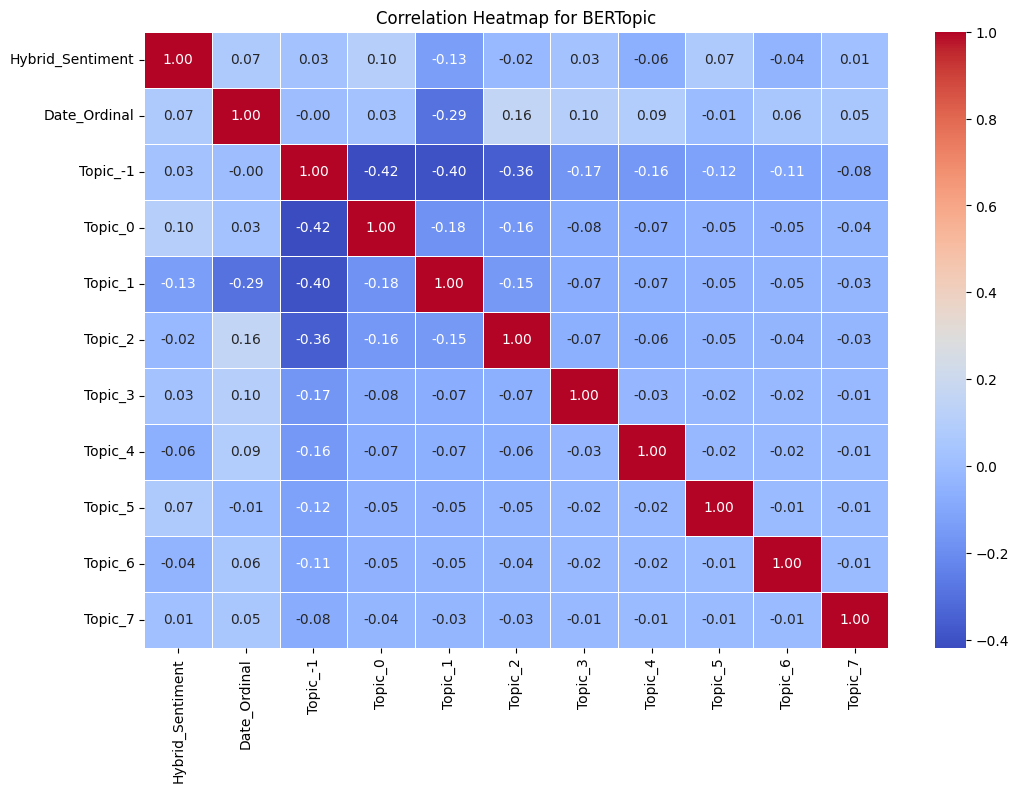

In [ ]:
if 'BERTopic_Optimal' in df.columns:
    topic_dummies_bt = pd.get_dummies(df['BERTopic_Optimal'], prefix='Topic')
    df_reg_bt = pd.concat([df, topic_dummies_bt], axis=1)
else:
    df_reg_bt = df.copy()

numeric_cols_bt = ['Hybrid_Sentiment', 'Date_Ordinal']
if 'BERTopic_Optimal' in df.columns:
    numeric_cols_bt.extend(topic_dummies_bt.columns.tolist())

# calculate the correlation matrix for the selected numeric columns.
corr_matrix_bt = df_reg_bt[numeric_cols_bt].corr()

# plot the correlation heatmap using seaborn.
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_bt, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for BERTopic")
plt.show()

# Time Trend

In [ ]:
df = pd.read_csv("reddit_ubisoft_lda_bertopic_optimal_topics.csv")

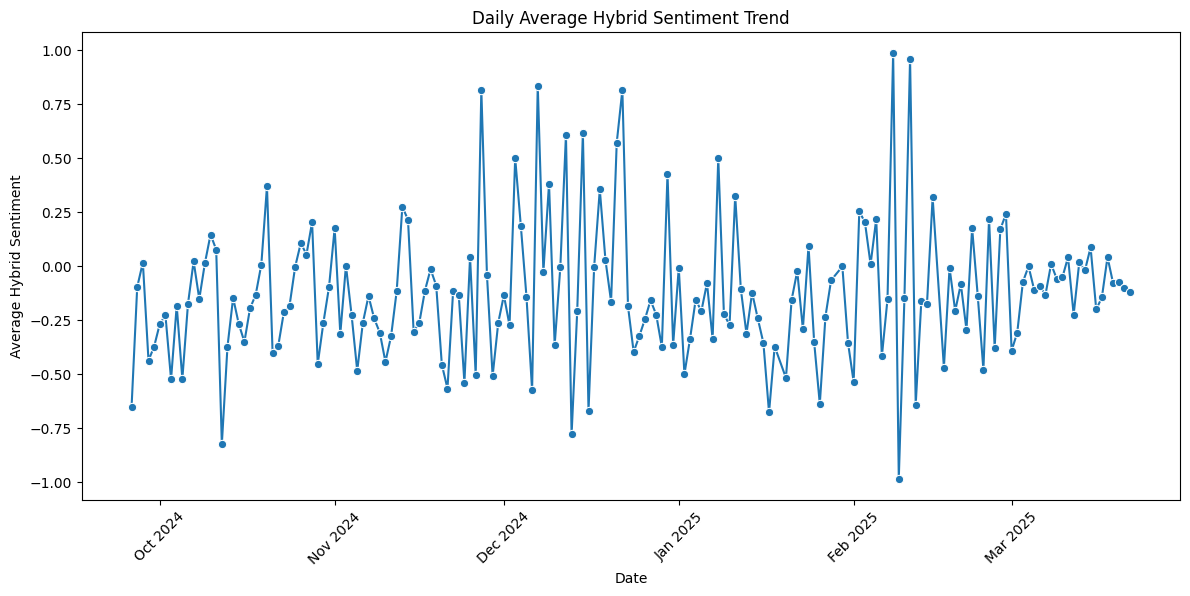

High Average Sentiment Days:
133   2025-02-08
136   2025-02-11
72    2024-12-07
Name: Posted Date, dtype: datetime64[ns]

Posts from High Sentiment Spike Days:
             Posted Date                                               Text  \
1575 2024-12-07 02:35:56  honestly even though gaming market flooded rem...   
1379 2025-02-08 17:43:55  got gifted ubisoft classic subscription six mo...   
1375 2025-02-11 10:17:14  believe watch dog series could seamlessly evol...   
1374 2025-02-11 17:10:00  recently playing farcry loved great game atten...   

                                                    URL  BERTopic_Topic  
1575             https://www.reddit.com/gallery/1h8ikw5               2  
1379  https://www.reddit.com/r/ubisoft/comments/1iks...              -1  
1375             https://www.reddit.com/gallery/1imvfo9               2  
1374  https://www.reddit.com/r/ubisoft/comments/1in3...              -1  

--------------------------------------------------

Low Average Sentiment

In [ ]:
# --- STEP 1: Daily Trend Plot ---
df['Posted Date'] = pd.to_datetime(df['Posted Date'], errors='coerce')
df = df.dropna(subset=['Posted Date'])
df = df[df['Posted Date'] >= pd.Timestamp("2024-07-01")]

# group by day and calculate the average Hybrid_Sentiment
daily_trend = df.groupby(df['Posted Date'].dt.date)['Hybrid_Sentiment'].mean().reset_index()
daily_trend['Posted Date'] = pd.to_datetime(daily_trend['Posted Date'])
daily_trend = daily_trend[daily_trend['Posted Date'].dt.year != 2022]

# plot the overall daily trend
plt.figure(figsize=(12, 6))
sns.lineplot(x='Posted Date', y='Hybrid_Sentiment', data=daily_trend, marker='o')
plt.title("Daily Average Hybrid Sentiment Trend")
plt.xlabel("Date")
plt.ylabel("Average Hybrid Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
date_formatter = DateFormatter("%b %Y")
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.show()

# --- STEP 2: Identify Spike Days ---
# select top 3 days with highest average sentiment and bottom 3 with lowest average sentiment
top_3_days = daily_trend.nlargest(3, 'Hybrid_Sentiment')['Posted Date']
bottom_3_days = daily_trend.nsmallest(3, 'Hybrid_Sentiment')['Posted Date']

# --- STEP 3: Inspect Posts Separately ---
# high sentiment spike days
df_spikes_high = df[df['Posted Date'].dt.date.isin(top_3_days.dt.date)]
print("High Average Sentiment Days:")
print(top_3_days)
print("\nPosts from High Sentiment Spike Days:")
print(df_spikes_high[['Posted Date', 'Text', 'URL', 'BERTopic_Topic']].sort_values('Posted Date'))

print("\n" + "-"*50 + "\n")

# low sentiment spike days
df_spikes_low = df[df['Posted Date'].dt.date.isin(bottom_3_days.dt.date)]
print("Low Average Sentiment Days:")
print(bottom_3_days)
print("\nPosts from Low Sentiment Spike Days:")
print(df_spikes_low[['Posted Date', 'Text', 'URL', 'BERTopic_Topic']].sort_values('Posted Date'))

In [ ]:
# initialize the emotion classification pipeline
emotion_classifier = pipeline("text-classification",
                              model="j-hartmann/emotion-english-distilroberta-base",
                              return_all_scores=True
                              )

def get_emotion(text):
    if not isinstance(text, str) or not text.strip():
        return None
    scores = emotion_classifier(text, truncation=True, max_length=512)[0]
    # select the emotion with the highest score
    dominant_emotion = max(scores, key=lambda x: x['score'])['label']
    return dominant_emotion

df['Predicted_Emotion'] = df['Text'].apply(get_emotion)
print(df[['Text', 'Predicted_Emotion']].head())

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


                                                Text Predicted_Emotion
0  hello everyone megathread dedicated discussing...           neutral
1  hello everyone game releasing week similarly r...           neutral
2                      best looking game ever played           neutral
3  game nothing short straight ninja shit touched...               joy
4  first recorded ttp time penis assassin creed s...           neutral


In [ ]:
df.to_csv("reddit_ubisoft_emo.csv", index=False)

Optimal BERTopic: [0, 1, 2, 3, 4, 5, 6, 7, 8]


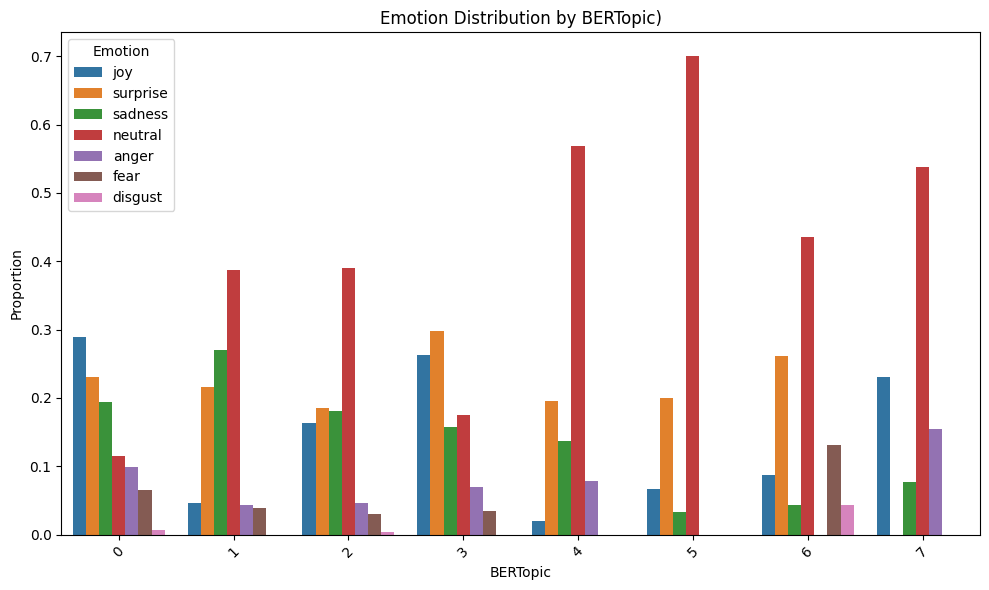

In [ ]:
# 1. define "optimal" BERTopic topics.
optimal_topic_list = list(range(optimal_topics))

print(f"Optimal BERTopic: {optimal_topic_list}")

# 2. filter the DataFrame to include only the optimal topic number
df_optimal_bertopic = df[df['BERTopic_Optimal'].isin(optimal_topic_list)]

# 3. compute the normalized emotion distribution by BERTopic_Topic
emotion_topic_bertopic = (
    df_optimal_bertopic.groupby('BERTopic_Optimal')['Predicted_Emotion']
    .value_counts(normalize=True)
    .rename('Proportion')
    .reset_index()
)

# 4. plot a bar chart of the emotion distribution by BERTopic topic
plt.figure(figsize=(10, 6))
sns.barplot(
    x='BERTopic_Optimal',
    y='Proportion',
    hue='Predicted_Emotion',
    data=emotion_topic_bertopic
)

plt.title(f"Emotion Distribution by BERTopic)")
plt.xlabel("BERTopic")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title='Emotion')
plt.tight_layout()
plt.show()


In [ ]:
# find the post with the highest sentiment score
max_sentiment_row = df.loc[df['Hybrid_Sentiment'].idxmax()]

# find the post with the lowest sentiment score
min_sentiment_row = df.loc[df['Hybrid_Sentiment'].idxmin()]

print("Post with Highest Sentiment Score:")
print("Title:", max_sentiment_row['Title'])
print("Posted Date:", max_sentiment_row['Posted Date'])
print("Hybrid Sentiment:", max_sentiment_row['Hybrid_Sentiment'])
print("Text:", max_sentiment_row['Text'])
print("Emotion:", max_sentiment_row['Predicted_Emotion'])
print("\n----------------------------\n")
print("Post with Lowest Sentiment Score:")
print("Title:", min_sentiment_row['Title'])
print("Posted Date:", min_sentiment_row['Posted Date'])
print("Hybrid Sentiment:", min_sentiment_row['Hybrid_Sentiment'])
print("Text:", min_sentiment_row['Text'])
print("Emotion:", min_sentiment_row['Predicted_Emotion'])


Post with Highest Sentiment Score:
Title: assassin creed shadow review megathread
Posted Date: 2025-03-18 17:01:35
Hybrid Sentiment: 0.9980776607990264
Text: game information game title assassin creed shadow platform playstation mar pc mar xbox series x mar trailer assassin creed shadow world trailer assassin creed shadow one duo two playstyles assassin creed shadow official gameplay combat stealth evolved ubisoft forward developer ubisoft quebec publisher ubisoft review aggregator opencritic average recommended review critic review gaming network marcel dee ubisoft finally given fan feudal japan assassin creed experience dreamed stunning visuals fluid gameplay deeply immersive world assassin creed shadow stand tall one best entry series beautiful assassin creed game ever acg jeremy penter unscored assassin creed shadow glacial starting get better change ai combat make enjoyable expected like ac game love atmosphere analog stick gaming jeff young truly wonderful writing engaging pair p